# Socio-Economic Advantage

Within this package, the seifa_vic submodule allows for suburb level aggregation of socio economic data derived by Australian Bureau of Statistics from census data every 5 years.

## Data access

When this module is first run, it will pull down datasets from the Australian Bureau of Statistics, The State of Victoria Data repository, and AURIN. You will need to have an API access key and code in order to download the aurin data. You can get one by filling out the form at this [link](https://aurin.org.au/resources/aurin-apis/sign-up/).

Once the form is filled out, you will be sent a username and password to be able to pull requests from the API.

### Storing the aurin api credentials in a config.ini

The username and password can either be entered into a config file in package repository folder in the config.ini file, copying the following example:

```toml
[aurin]
username = {your_aurin_username}
password = {your_aurin_password}
```

### Entering the aurin credentials on execution

However, if you do not set up the configuration file, you will be asked to enter your credentials when you run the seifa_vic module for the first time, and these will be saved with your user data.

## Using the seifa_vic command line utility:

The Socio-economic data can be interpolated from the command line with the following command:

```bash
ausdex seifa-vic [OPTIONS] YEAR_VALUE SUBURB METRIC
```

where:

- `YEAR_VALUE`: Is the year or datetime value to interpolate
- `SUBURB`: is the name of the suburb to interpolate to (capitalisation doesnt matter)
- `METRIC`: is the name of the metric to interpolate:
  - `irsd_score` for index of relative socio economic disadvantage,
  - `ieo_score` for the index of education and opportunity, 
  - `ier_score` for an index of economic resources
  - `irsad_score` for index of socio economic advantage and disadvantage,
  - `uirsa_score` for the urban index of relative socio economic advantage,
  - `rirsa_score` for the rural index of relative socio economic advantage
- `--lga`: name of the local goverment area, used if the suburb name is repeated multiple times in the state (ie Ascot in ballarat, and Ascot in Greater Bendigo
- `--fill-value`: optional input that dictates how the data are extrapolated outside the year range of the dataset. default is `null` which returns `np.nan` values. Other options include `extrapolate`, which extrapolates the data, `boundary_value` which takes the nearest data point, and options defined in the [scipy.interpolate.interp1d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html) `fill_value` optional argument.
- `--guess-misspelt`: If true, then if it cannot find a match for the name of the suburb then it finds the closest name to it.

## Using the seifa_vic module:
Once the data is loaded and ready to go, you can start making socio economic calculations
See below for a high level example of the `interpolate_vic_suburb_seifa` function.

In [1]:
import warnings
warnings.filterwarnings('ignore')

### Calculating one value

In [2]:
from ausdex.seifa_vic import interpolate_vic_suburb_seifa, get_repeated_names

The interpolate_vic_suburb_seifa function takes the same arguments as the command line:

```python
interpolate_vic_suburb_seifa(
    year_values: Union[int, float,str,  np.datetime64, datetime.datetime, np.array,pd.Series, mpd.Series, list], 
    suburb:  Union[str, np.array,  list, pd.Series, mpd.Series],
    metric: str,
    lga: Union[None, str, np.array,pd.Series, mpd.Series, list ]=None, 
    fill_value: str ="null",
     **kwargs
) -> np.array or float
```

In [3]:
interpolate_vic_suburb_seifa(2007, 'FOOTSCRAY', 'ier_score', fill_value='null')

872.5409546327359

# Guessing Misspelt Suburb Names

If you select the option to `guess_misspelt` then if it cannot find a match for the name of the suburb then it finds the closest name to it. For example, 'FOOTSCRAY' here has an extra 'O' but it still finds the correct suburb:

In [5]:
interpolate_vic_suburb_seifa(2007, 'FOOOTSCRAY', 'ier_score', fill_value='null', guess_misspelt=True)

872.5409546327359

### Calculation of multiple values

You can calculate multiple years by feeding in an np.array like for the year argument

In [4]:
interpolate_vic_suburb_seifa([2007, 2020], 'FOOTSCRAY', 'ier_score', fill_value='extrapolate')

array([872.54095463, 824.12602533])

You can also add in multiple suburbs (in a `list`, `np.array`, or `pd.Series`, which will return a value for each year (or datetime) and suburb pair:

In [5]:
import numpy as np
import pandas as pd
interpolate_vic_suburb_seifa(np.array(['31-05-2010', '10-03-1988', '10-03-2025']), 
                             pd.Series(['FOOTSCRAY', 'abbotsford', 'Parkville']), 'ier_score')

array([862.77569946, 978.37269243,          nan])

**Note:** year values can take in an integer or float year, or any sort of datetime format acceptable to `pd.Timestamp`. and suburbs can be in any kind of case. date time values are interpolated at monthly resolution.

#### Suburbs with repeated names

Several suburb names in victoria are repeated in different local government areas. These are listed with the following formate `"{suburb_name} - {council_name}"` The list of these names can be found using the `get_repeated_names` function


In [6]:
get_repeated_names()

['ASCOT - BALLARAT',
 'ASCOT - GREATER BENDIGO',
 'BELLFIELD - BANYULE',
 'BELLFIELD - GRAMPIANS',
 'BIG HILL - GREATER BENDIGO',
 'BIG HILL - SURF COAST',
 'FAIRY DELL - CAMPASPE',
 'FAIRY DELL - EAST GIPPSLAND',
 'FRAMLINGHAM - MOYNE',
 'GOLDEN POINT - BALLARAT',
 'GOLDEN POINT - CENTRAL GOLDFIELDS',
 'GOLDEN POINT - MOUNT ALEXANDER',
 'HAPPY VALLEY - GOLDEN PLAINS',
 'HAPPY VALLEY - SWAN HILL',
 'HILLSIDE - EAST GIPPSLAND',
 'HILLSIDE - MELTON',
 'KILLARA - GLENELG',
 'KILLARA - WODONGA',
 'MERRIJIG - EAST GIPPSLAND',
 'MERRIJIG - MANSFIELD',
 'MERRIJIG - WANGARATTA',
 'MOONLIGHT FLAT - CENTRAL GOLDFIELDS',
 'MOONLIGHT FLAT - MOUNT ALEXANDER',
 'MYALL - BULOKE',
 'MYALL - GANNAWARRA',
 'NEWTOWN - GOLDEN PLAINS',
 'NEWTOWN - GREATER GEELONG',
 'REEDY CREEK - MITCHELL',
 'SPRINGFIELD - MACEDON RANGES',
 'SPRINGFIELD - SWAN HILL',
 'STONY CREEK - HEPBURN',
 'STONY CREEK - SOUTH GIPPSLAND',
 'THOMSON - BAW BAW',
 'THOMSON - GREATER GEELONG']

### Addressing repeated names

In order to address the repeated names issue, you can do one of two things
- use the `"{suburb} - {local_government_area}"` format in the suburb command
- or use the `lga` optional argument to include the lga for the suburb

In [7]:
interpolate_vic_suburb_seifa([2007, 2020], 'ASCOT - BALLARAT', 'ier_score', fill_value='extrapolate')

array([1099.06088154, 1026.49932655])

In [8]:
interpolate_vic_suburb_seifa([2007, 2020], 'ASCOT', 'ier_score',lga="ballarat", fill_value='extrapolate')

array([1099.06088154, 1026.49932655])

In [12]:
# it even works with an array-like of lga values
interpolate_vic_suburb_seifa(np.array(['31-05-2010', '10-03-1988', '10-03-2025']), 
                             pd.Series(['Ascot', 'Ascot', 'Abbotsford']), 'ier_score',
                             lga = ['ballarat', 'greater bendigo', 'Yarra']
                            )

array([1084.16837443, 1052.41809538,           nan])

### Different methods of extrapolation
The default setting is for the interpolator to extrapolate out to values before and after the first and last years in the dataset, this is set with the `fill_value` optional argument.

Other options include `"boundary_value"` which will set variables outside of the time span of data to the nearest data points. See below for an illustration

In [13]:
import pandas as pd

years = list(range(1980, 2020))
abbotsford_ier = interpolate_vic_suburb_seifa(years, 'abbotsford', 'ier_score', fill_value='boundary_value')
df = pd.DataFrame({'years':years, 'ier_boundary':abbotsford_ier})
df['ier_extrapolate'] = interpolate_vic_suburb_seifa(years, 'ABBOTSFORD', 'ier_score', fill_value='extrapolate')

In [14]:
df.head()


years  ier_boundary  ier_extrapolate
0   1980    943.031533       868.191431
1   1981    943.031533       880.664782
2   1982    943.031533       893.138132
3   1983    943.031533       905.611482
4   1984    943.031533       918.084833

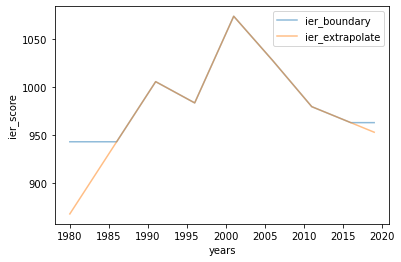

In [15]:

ax = df.plot(x='years', y=['ier_boundary', 'ier_extrapolate'], alpha=0.5)
ax.set_ylabel('ier_score');


Note that the above graph shows the boundary_value vs the extrapolate fill_value patterns

## Getting seifa gis data:

Additional functions have been created to suburb vector files with interpolated seifa values for a given date time.

### Via the command line:

You can create and save gis files for a given time period using the following command line function:

```bash
ausdex seifa-vic-gis [OPTIONS] DATE METRIC:[ier_score|irsd_score|ieo_sc
                            ore|irsad_score|rirsa_score|uirsa_score] OUT

```

with the following inputs and options:

- `DATE` (int, float, str): Year values in decimal years or in a
  string datetime format convertable by pandas.to_datetime function

- `METRIC`: is the name of the metric to interpolate:
  - `irsd_score` for index of relative socio economic disadvantage,
  - `ieo_score` for the index of education and opportunity, 
  - `ier_score` for an index of economic resources
  - `irsad_score` for index of socio economic advantage and disadvantage,
  - `uirsa_score` for the urban index of relative socio economic advantage,
  - `rirsa_score` for the rural index of relative socio economic advantage

- `OUT` (Path): Path to save html graph to.

- `--fill-value` (str): optional input that dictates how the data are extrapolated outside the year range of the dataset. default is `null` which returns `np.nan` values. Other options include `extrapolate`, which extrapolates the data, `boundary_value` which takes the nearest data point, and options defined in the [scipy.interpolate.interp1d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html) `fill_value` optional argument.


  
## Getting GIS data from the module:
You can also create vector datasets within python, this will return a pandas geodataframe with the interpolated value for each suburb

In [1]:
from ausdex.seifa_vic import get_seifa_gis

In [2]:
gdf = get_seifa_gis('12-12-2015', 'ier_score', fill_value='extrapolate')

In [3]:
gdf.head()

id  ...    ier_score
0  ckan_af33dd8c_0534_4e18_9245_fc64440f742e.1  ...  1082.654948
1  ckan_af33dd8c_0534_4e18_9245_fc64440f742e.2  ...   981.000134
2  ckan_af33dd8c_0534_4e18_9245_fc64440f742e.3  ...  1045.190009
3  ckan_af33dd8c_0534_4e18_9245_fc64440f742e.4  ...   991.000001
4  ckan_af33dd8c_0534_4e18_9245_fc64440f742e.5  ...  1013.999952

[5 rows x 16 columns]

<AxesSubplot:>

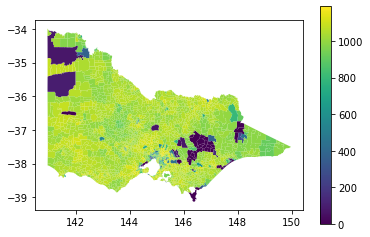

In [5]:
gdf.plot('ier_score', legend = True)